In [60]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
import sklearn.metrics as metrics
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.decomposition import PCA
from scipy.stats import boxcox, probplot, norm, shapiro
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_fscore_support, roc_auc_score, precision_recall_curve, average_precision_score, log_loss, confusion_matrix, f1_score, precision_score, recall_score
import os
import warnings
warnings.filterwarnings('ignore')

# Funciones

In [62]:
def relaciones_vs_target(X, Y, return_type='axes'):
    fig_tot = (len(X.columns))
    fig_por_fila = 4.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1',
                          label_0='Clase 0', density=0):
    '''
    Función que recibe dos distribuciones de probabilidad y las representa
    en el mismo gráfico
    '''
    bins = n_bins
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='red')
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best')

def hist_pos_neg_feat(x, y, density=0, nbins=11, targets=(0,1)):
    '''
    Representa las variables en x divididas en dos distribuciones
    según su valor de y sea 1 o 0
    '''
    fig_tot = len(x.columns)
    fig_tot_fila = 4.; fig_tamanio = 4.
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins,
                   density = density, title=('%s' % feat))
def reporting_modelo(y_reales, y_clase):
    matriz_confusion = metrics.confusion_matrix(y_reales, y_clase)
    roc_auc = metrics.roc_auc_score(y_reales, y_clase)
    metrica_f1 = metrics.f1_score(y_reales, y_clase)
    print(u'La AUC de la ROC es de: {}'.format(round(roc_auc,2)))
    print(u'La F1 es de: {}'.format(round(metrica_f1,2)))
    print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_reales, y_clase),3)))
    print("Sensitividad\t{}".format(round(metrics.recall_score(y_reales, y_clase),3)))
    print(u"Precisión\t{}".format(round(metrics.precision_score(y_reales, y_clase),3)))
    repre_matriz_confusion(matriz_confusion)
def comprueba_normalidad(df, return_type='axes', title='Comprobación de normalidad'):
    '''
    '''
    fig_tot = (len(df.columns))
    fig_por_fila = 3.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+2 ) )
    c = 0
    shapiro_test = {}
    lambdas = {}
    for i, col in enumerate(df.columns):
        ax = plt.subplot(num_filas, fig_por_fila, i+1)
        probplot(x = df[df.columns[i]], dist=norm, plot=ax)
        plt.title(df.columns[i])
        shapiro_test[df.columns[i]] = shapiro(df[df.columns[i]])
    plt.suptitle(title)
    plt.show()
    shapiro_test = pd.DataFrame(shapiro_test, index=['Test Statistic', 'p-value']).transpose()
    return shapiro_test

# Lectura y descripción de los datos

In [63]:
XY = pd.read_csv('./partidos_Grand_Slam.csv')
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Nombres de las variables: {}'.format(list(XY.columns)))
XY

- El número de filas en el dataset es: 169
- El número de columnas en el dataset es: 17
- Nombres de las variables: ['rank', 'name', 'country_name', 'country_id', 'ACES', 'ST partidos jugados', 'ST partidos ganados', 'ST juegos saque ganados ', 'ST dobles faltas', 'ST primer servicio ganado ', 'ST segundo servicio ganado ', 'ST puntos break contra partido', 'ST puntos totales ganados', 'ST puntos devueltos ganados ', 'ST tie brieks jugados', 'ST tie brieks ganados', 'ST  total juegos ganados']


,rank,name,country_name,country_id,ACES,ST partidos jugados,ST partidos ganados,ST juegos saque ganados,ST dobles faltas,ST primer servicio ganado,ST segundo servicio ganado,ST puntos break contra partido,ST puntos totales ganados,ST puntos devueltos ganados,ST tie brieks jugados,ST tie brieks ganados,ST total juegos ganados
0,1,Nick Kyrgios,Australia,AUS,304,13.0,10.0,91.27,56,77.23,53.14,6.54,1600.0,33.95,11.0,7.0,274.0
1,2,John Isner,United States,USA,245,8.0,5.0,92.66,28,81.38,56.01,5.25,1061.0,27.85,13.0,9.0,178.0
2,3,Marin Cilic,Croatia,CRO,235,14.0,11.0,88.21,65,80.12,53.65,6.71,1633.0,39.09,8.0,5.0,282.0
3,4,Felix Auger Aliassime,Canada,CAN,191,12.0,8.0,87.34,62,77.03,49.91,7.83,1553.0,34.92,13.0,9.0,244.0
4,5,Daniil Medvedev,Russian Federation,RUS,183,15.0,12.0,86.15,63,75.66,52.59,7.43,1617.0,40.87,9.0,6.0,291.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,161,Paul Jubb,United Kingdom,GBR,5,NaN,NaN,80.77,7,70.30,56.36,NaN,152.0,30.86,NaN,NaN,23.0
165,166,Ernesto Escobedo,United States,USA,3,NaN,NaN,NaN,5,70.59,51.11,NaN,126.0,33.08,NaN,NaN,NaN
166,166,Juan Manuel Cerundolo,Argentina,ARG,3,NaN,NaN,NaN,4,61.04,42.86,NaN,NaN,NaN,NaN,NaN,NaN
167,168,Michael Mmoh,United States,USA,2,NaN,NaN,NaN,2,59.60,50.00,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
XY.describe()

,rank,ACES,ST partidos jugados,ST partidos ganados,ST juegos saque ganados,ST dobles faltas,ST primer servicio ganado,ST segundo servicio ganado,ST puntos break contra partido,ST puntos totales ganados,ST puntos devueltos ganados,ST tie brieks jugados,ST tie brieks ganados,ST total juegos ganados
count,169.000000,169.000000,95.000000,95.000000,160.000000,169.000000,169.000000,169.000000,95.000000,167.000000,166.000000,119.000000,119.000000,160.000000
mean,84.100592,50.224852,8.357895,4.852632,77.259625,24.497041,70.153077,49.647692,9.626947,665.491018,35.365361,4.873950,2.504202,109.062500
std,48.341130,52.305163,3.655121,3.820350,7.690446,19.510414,5.608208,5.509109,2.342884,486.738938,3.936519,3.107003,2.216555,82.705181
min,1.000000,1.000000,5.000000,1.000000,53.850000,0.000000,50.560000,32.260000,5.250000,96.000000,24.800000,2.000000,0.000000,17.000000
25%,42.000000,16.000000,6.000000,2.000000,73.115000,10.000000,66.950000,46.070000,7.830000,298.000000,32.395000,3.000000,1.000000,47.750000
50%,84.000000,31.000000,7.000000,4.000000,77.495000,20.000000,70.370000,50.460000,9.400000,554.000000,35.540000,4.000000,2.000000,89.500000
75%,127.000000,62.000000,10.000000,6.500000,82.387500,31.000000,74.070000,53.490000,11.000000,807.000000,38.100000,6.000000,3.000000,138.250000
max,169.000000,304.000000,23.000000,22.000000,92.660000,94.000000,81.380000,63.040000,15.330000,2564.000000,43.710000,15.000000,12.000000,461.000000


## Extracción, Transformación y Limpieza de datos

In [65]:
# Comprobamos los valores missing que existen
XY.isnull().sum()

rank                               0
name                               0
country_name                       0
country_id                         0
ACES                               0
ST partidos jugados               74
ST partidos ganados               74
ST juegos saque ganados            9
ST dobles faltas                   0
ST primer servicio ganado          0
ST segundo servicio ganado         0
ST puntos break contra partido    74
ST puntos totales ganados          2
ST puntos devueltos ganados        3
ST tie brieks jugados             50
ST tie brieks ganados             50
ST  total juegos ganados           9
dtype: int64

In [66]:
# Vemos que hay 8 columnas que contienen valores faltantes, por lo que procedemos a eliminarlos
XY = XY.dropna()

In [67]:
XY.isnull().sum()

rank                              0
name                              0
country_name                      0
country_id                        0
ACES                              0
ST partidos jugados               0
ST partidos ganados               0
ST juegos saque ganados           0
ST dobles faltas                  0
ST primer servicio ganado         0
ST segundo servicio ganado        0
ST puntos break contra partido    0
ST puntos totales ganados         0
ST puntos devueltos ganados       0
ST tie brieks jugados             0
ST tie brieks ganados             0
ST  total juegos ganados          0
dtype: int64

In [68]:
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Nombres de las variables: {}'.format(list(XY.columns)))
XY

- El número de filas en el dataset es: 84
- El número de columnas en el dataset es: 17
- Nombres de las variables: ['rank', 'name', 'country_name', 'country_id', 'ACES', 'ST partidos jugados', 'ST partidos ganados', 'ST juegos saque ganados ', 'ST dobles faltas', 'ST primer servicio ganado ', 'ST segundo servicio ganado ', 'ST puntos break contra partido', 'ST puntos totales ganados', 'ST puntos devueltos ganados ', 'ST tie brieks jugados', 'ST tie brieks ganados', 'ST  total juegos ganados']


,rank,name,country_name,country_id,ACES,ST partidos jugados,ST partidos ganados,ST juegos saque ganados,ST dobles faltas,ST primer servicio ganado,ST segundo servicio ganado,ST puntos break contra partido,ST puntos totales ganados,ST puntos devueltos ganados,ST tie brieks jugados,ST tie brieks ganados,ST total juegos ganados
0,1,Nick Kyrgios,Australia,AUS,304,13.0,10.0,91.27,56,77.23,53.14,6.54,1600.0,33.95,11.0,7.0,274.0
1,2,John Isner,United States,USA,245,8.0,5.0,92.66,28,81.38,56.01,5.25,1061.0,27.85,13.0,9.0,178.0
2,3,Marin Cilic,Croatia,CRO,235,14.0,11.0,88.21,65,80.12,53.65,6.71,1633.0,39.09,8.0,5.0,282.0
3,4,Felix Auger Aliassime,Canada,CAN,191,12.0,8.0,87.34,62,77.03,49.91,7.83,1553.0,34.92,13.0,9.0,244.0
4,5,Daniil Medvedev,Russian Federation,RUS,183,15.0,12.0,86.15,63,75.66,52.59,7.43,1617.0,40.87,9.0,6.0,291.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,122,Jenson Brooksby,United States,USA,18,7.0,4.0,76.60,12,65.00,53.40,7.86,616.0,40.80,2.0,2.0,99.0
123,124,Federico Delbonis,Argentina,ARG,17,5.0,1.0,70.13,20,66.06,47.59,9.40,463.0,34.09,3.0,1.0,68.0
126,127,Albert Ramos,Spain,ESP,16,6.0,2.0,73.91,20,63.94,51.57,15.33,772.0,37.59,6.0,2.0,112.0
130,129,Sebastian Baez,Argentina,ARG,15,7.0,3.0,72.00,24,63.48,46.98,12.57,799.0,38.16,2.0,1.0,119.0


In [69]:
# Mostramos las variables categóricas
XY.select_dtypes(exclude=['number']).columns

Index(['name', 'country_name', 'country_id'], dtype='object')

In [70]:
# Initialize LabelEncoder
le_name = LabelEncoder()
le_country_name = LabelEncoder()
le_country_id = LabelEncoder()

In [71]:
# Fit and transform the categorical variables
XY['name'] = le_name.fit_transform(XY['name'].values)
XY['country_name'] = le_country_name.fit_transform(XY['country_name'].values)
XY['country_id'] = le_country_id.fit_transform(XY['country_id'].values)

In [72]:
# Con Laber Encoder se codifican las variables categoricas a números diferentes
le = LabelEncoder()

In [73]:
XY['name'].value_counts()

name
62    1
41    1
37    1
5     1
25    1
     ..
55    1
4     1
64    1
18    1
65    1
Name: count, Length: 84, dtype: int64

In [74]:
XY['country_name'].value_counts()

country_name
29    11
10     9
27     9
1      8
24     5
28     4
0      4
23     4
15     4
19     3
5      2
6      2
21     2
14     1
9      1
25     1
11     1
18     1
2      1
16     1
8      1
26     1
4      1
3      1
12     1
20     1
13     1
17     1
7      1
22     1
Name: count, dtype: int64

In [75]:
XY['country_id'].value_counts()

country_id
29    11
11     9
10     9
1      8
27     5
12     4
0      4
25     4
17     4
21     3
5      2
6      2
23     2
16     1
9      1
28     1
13     1
20     1
3      1
18     1
8      1
26     1
4      1
2      1
14     1
22     1
15     1
19     1
7      1
24     1
Name: count, dtype: int64

In [76]:
# Usamos Laber Encoder ya que le asignará un valor diferente, comenzando desde 0 a cada nombre. Lo mismo para country_name y country_id
XY.name= le.fit_transform(XY.name.values)
XY.country_name= le.fit_transform(XY.country_name.values)
XY.country_id= le.fit_transform(XY.country_id.values)

In [77]:
XY.select_dtypes(exclude=['number']).columns

Index([], dtype='object')

In [78]:
XY

,rank,name,country_name,country_id,ACES,ST partidos jugados,ST partidos ganados,ST juegos saque ganados,ST dobles faltas,ST primer servicio ganado,ST segundo servicio ganado,ST puntos break contra partido,ST puntos totales ganados,ST puntos devueltos ganados,ST tie brieks jugados,ST tie brieks ganados,ST total juegos ganados
0,1,62,1,1,304,13.0,10.0,91.27,56,77.23,53.14,6.54,1600.0,33.95,11.0,7.0,274.0
1,2,48,29,29,245,8.0,5.0,92.66,28,81.38,56.01,5.25,1061.0,27.85,13.0,9.0,178.0
2,3,57,7,7,235,14.0,11.0,88.21,65,80.12,53.65,6.71,1633.0,39.09,8.0,5.0,282.0
3,4,32,5,5,191,12.0,8.0,87.34,62,77.03,49.91,7.83,1553.0,34.92,13.0,9.0,244.0
4,5,26,23,25,183,15.0,12.0,86.15,63,75.66,52.59,7.43,1617.0,40.87,9.0,6.0,291.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,122,45,29,29,18,7.0,4.0,76.60,12,65.00,53.40,7.86,616.0,40.80,2.0,2.0,99.0
123,124,31,0,0,17,5.0,1.0,70.13,20,66.06,47.59,9.40,463.0,34.09,3.0,1.0,68.0
126,127,1,27,10,16,6.0,2.0,73.91,20,63.94,51.57,15.33,772.0,37.59,6.0,2.0,112.0
130,129,72,0,0,15,7.0,3.0,72.00,24,63.48,46.98,12.57,799.0,38.16,2.0,1.0,119.0


## Matriz de correlación

In [79]:
# Calcular la matriz de correlación
correlation = XY.corr()
correlation

,rank,name,country_name,country_id,ACES,ST partidos jugados,ST partidos ganados,ST juegos saque ganados,ST dobles faltas,ST primer servicio ganado,ST segundo servicio ganado,ST puntos break contra partido,ST puntos totales ganados,ST puntos devueltos ganados,ST tie brieks jugados,ST tie brieks ganados,ST total juegos ganados
rank,1.000000,-0.029618,-0.041030,-0.172096,-0.820357,-0.565331,-0.573607,-0.790350,-0.506574,-0.856590,-0.235167,0.573593,-0.578137,0.047950,-0.552474,-0.568374,-0.602220
name,-0.029618,1.000000,0.077286,0.163246,0.074586,-0.027251,-0.019192,0.018500,-0.052242,0.039077,0.046118,-0.019844,-0.037625,-0.249402,-0.087510,0.011413,-0.027654
country_name,-0.041030,0.077286,1.000000,0.787455,0.053449,0.143490,0.148404,0.172456,-0.089449,0.081434,0.353185,-0.218965,0.140207,0.046764,0.156337,0.121400,0.152845
country_id,-0.172096,0.163246,0.787455,1.000000,0.167931,0.099732,0.094875,0.241188,-0.081697,0.232183,0.216781,-0.241642,0.083458,-0.095011,0.188965,0.161450,0.094072
ACES,-0.820357,0.074586,0.053449,0.167931,1.000000,0.602149,0.612387,0.785096,0.523471,0.773900,0.279332,-0.590419,0.628967,-0.086960,0.669389,0.684974,0.650764
ST partidos jugados,-0.565331,-0.027251,0.143490,0.099732,0.602149,1.000000,0.980051,0.513805,0.624724,0.350101,0.446455,-0.495512,0.977108,0.451160,0.563248,0.573757,0.982677
ST partidos ganados,-0.573607,-0.019192,0.148404,0.094875,0.612387,0.980051,1.000000,0.569281,0.589445,0.401273,0.460169,-0.529540,0.957197,0.464875,0.533342,0.578899,0.972334
ST juegos saque ganados,-0.790350,0.018500,0.172456,0.241188,0.785096,0.513805,0.569281,1.000000,0.391372,0.827128,0.488030,-0.759869,0.528290,-0.049905,0.599710,0.558849,0.568878
ST dobles faltas,-0.506574,-0.052242,-0.089449,-0.081697,0.523471,0.624724,0.589445,0.391372,1.000000,0.437986,0.045393,-0.264819,0.628408,0.125047,0.529943,0.463563,0.635761
ST primer servicio ganado,-0.856590,0.039077,0.081434,0.232183,0.773900,0.350101,0.401273,0.827128,0.437986,1.000000,0.124924,-0.639903,0.350911,-0.250891,0.480361,0.515890,0.390080


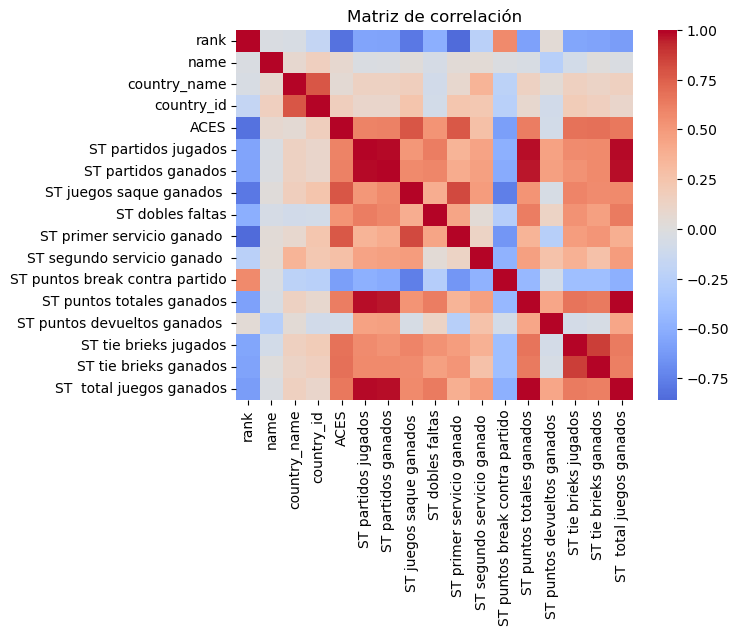

In [80]:
# Visualizar la matriz de correlación
sns.heatmap(correlation, cmap='coolwarm', center=0)
plt.title('Matriz de correlación')
plt.show()

## División de datos en conjunto y prueba

In [81]:
# Division de los datos en características (X) y variable objetivo (Y)
X = XY.drop('name', axis=1)
Y = XY['name']
X_nombres = X.columns
X_nombres

Index(['rank', 'country_name', 'country_id', 'ACES', 'ST partidos jugados',
       'ST partidos ganados', 'ST juegos saque ganados ', 'ST dobles faltas',
       'ST primer servicio ganado ', 'ST segundo servicio ganado ',
       'ST puntos break contra partido', 'ST puntos totales ganados',
       'ST puntos devueltos ganados ', 'ST tie brieks jugados',
       'ST tie brieks ganados', 'ST  total juegos ganados'],
      dtype='object')

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


## Definición del modelo

In [83]:
model = LogisticRegression()

## Entrenamiento del modelo

In [84]:
model.fit(X_train, y_train)

LogisticRegression()

## Mostreo de variables con mas correlación

array([[<Axes: title={'center': 'rank'}>,
        <Axes: title={'center': 'country_name'}>,
        <Axes: title={'center': 'country_id'}>,
        <Axes: title={'center': 'ACES'}>],
       [<Axes: title={'center': 'ST partidos jugados'}>,
        <Axes: title={'center': 'ST partidos ganados'}>,
        <Axes: title={'center': 'ST juegos saque ganados '}>,
        <Axes: title={'center': 'ST dobles faltas'}>],
       [<Axes: title={'center': 'ST primer servicio ganado '}>,
        <Axes: title={'center': 'ST segundo servicio ganado '}>,
        <Axes: title={'center': 'ST puntos break contra partido'}>,
        <Axes: title={'center': 'ST puntos totales ganados'}>],
       [<Axes: title={'center': 'ST puntos devueltos ganados '}>,
        <Axes: title={'center': 'ST tie brieks jugados'}>,
        <Axes: title={'center': 'ST tie brieks ganados'}>,
        <Axes: title={'center': 'ST  total juegos ganados'}>]],
      dtype=object)

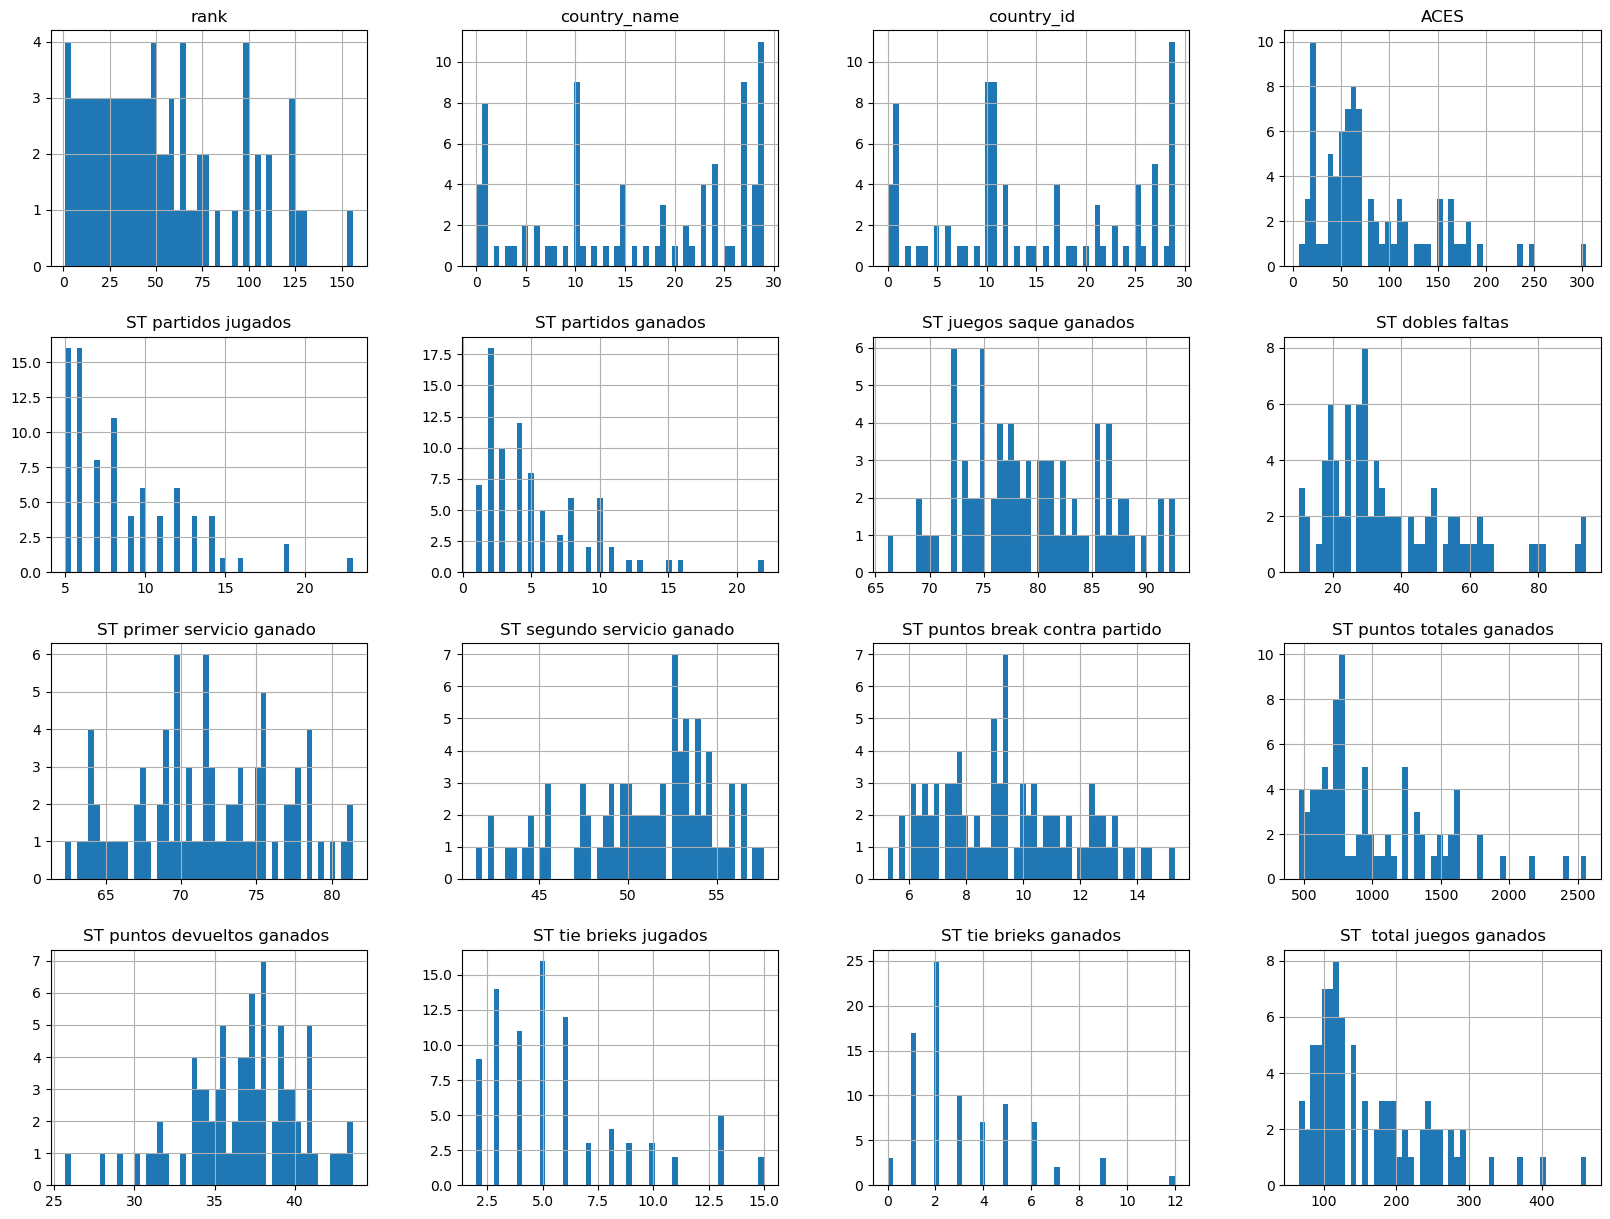

In [85]:
# Histograma de las variables para entender distribuciones
X.hist(bins=50, figsize=(20,15))

In [86]:
import pandas as pd

# Asume que tienes un archivo CSV llamado 'data.csv' en el mismo directorio donde estás ejecutando este script
df = pd.read_csv('C:\\Users\\camac\\OneDrive\\Escritorio\\Pablo Camacho\\partidos_Grand_Slam (3).csv')  # Cambia 'data.csv' por el nombre real y ruta de tu archivo CSV

# Verifica que los datos se han cargado correctamente viendo las primeras filas
print(df.head())

   rank                   name        country_name country_id  ACES  \
0     1           Nick Kyrgios           Australia        AUS   304   
1     2             John Isner       United States        USA   245   
2     3            Marin Cilic             Croatia        CRO   235   
3     4  Felix Auger Aliassime              Canada        CAN   191   
4     5        Daniil Medvedev  Russian Federation        RUS   183   

   ST partidos jugados  ST partidos ganados  ST juegos saque ganados   \
0                 13.0                 10.0                     91.27   
1                  8.0                  5.0                     92.66   
2                 14.0                 11.0                     88.21   
3                 12.0                  8.0                     87.34   
4                 15.0                 12.0                     86.15   

   ST dobles faltas  ST primer servicio ganado   ST segundo servicio ganado   \
0                56                       77.23       

In [87]:
print(X_train.dtypes)
print(X_test.dtypes)

rank                                int64
country_name                        int64
country_id                          int64
ACES                                int64
ST partidos jugados               float64
ST partidos ganados               float64
ST juegos saque ganados           float64
ST dobles faltas                    int64
ST primer servicio ganado         float64
ST segundo servicio ganado        float64
ST puntos break contra partido    float64
ST puntos totales ganados         float64
ST puntos devueltos ganados       float64
ST tie brieks jugados             float64
ST tie brieks ganados             float64
ST  total juegos ganados          float64
dtype: object
rank                                int64
country_name                        int64
country_id                          int64
ACES                                int64
ST partidos jugados               float64
ST partidos ganados               float64
ST juegos saque ganados           float64
ST dobles faltas    

In [110]:
# Verificar y manejar valores NaN o infinitos en X_train
X_train = X_train.fillna(0)
X_train.replace([np.inf, -np.inf], 0, inplace=True)

# Hacer lo mismo para X_test
X_test = X_test.fillna(0)
X_test.replace([np.inf, -np.inf], 0, inplace=True)

In [111]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train, has_constant='add')
X_test = sm.add_constant(X_test, has_constant='add')

In [112]:
try:
    model = sm.Logit(y_train, X_train)
    result = model.fit()
    print(result.summary())
except Exception as e:
    print("Error en el ajuste del modelo:", e)

         Current function value: inf
         Iterations: 35
Error en el ajuste del modelo: Singular matrix


In [113]:
from sklearn.linear_model import LogisticRegression

# Asegúrate de que no estás incluyendo la constante manualmente para scikit-learn
model_sklearn = LogisticRegression()
model_sklearn.fit(X_train.drop('const', axis=1, errors='ignore'), y_train)

# Ver coeficientes y rendimiento del modelo
print("Coeficientes:", model_sklearn.coef_)
print("Intercepción:", model_sklearn.intercept_)
print("Precisión en entrenamiento:", model_sklearn.score(X_train.drop('const', axis=1, errors='ignore'), y_train))

Coeficientes: [[ 0.00947798  0.03063362  0.05851269 -0.26732454 -0.30669306 -0.53166005
   0.03703201]]
Intercepción: [-0.0216541]
Precisión en entrenamiento: 0.9745762711864406


In [92]:
# Alinear X_train y X_test para asegurar que tienen las mismas columnas
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Revisar los nombres de las columnas para asegurarte de que ahora están alineados
print("Columnas en X_train:", X_train.columns)
print("Columnas en X_test:", X_test.columns)

Columnas en X_train: Index(['const', 'rank', 'country_name', 'country_id', 'ACES',
       'ST partidos jugados', 'ST partidos ganados',
       'ST juegos saque ganados ', 'ST dobles faltas',
       'ST primer servicio ganado ', 'ST segundo servicio ganado ',
       'ST puntos break contra partido', 'ST puntos totales ganados',
       'ST puntos devueltos ganados ', 'ST tie brieks jugados',
       'ST tie brieks ganados', 'ST  total juegos ganados'],
      dtype='object')
Columnas en X_test: Index(['const', 'rank', 'country_name', 'country_id', 'ACES',
       'ST partidos jugados', 'ST partidos ganados',
       'ST juegos saque ganados ', 'ST dobles faltas',
       'ST primer servicio ganado ', 'ST segundo servicio ganado ',
       'ST puntos break contra partido', 'ST puntos totales ganados',
       'ST puntos devueltos ganados ', 'ST tie brieks jugados',
       'ST tie brieks ganados', 'ST  total juegos ganados'],
      dtype='object')


Número de Coeficientes: 17
Número de Nombres de Características: 17


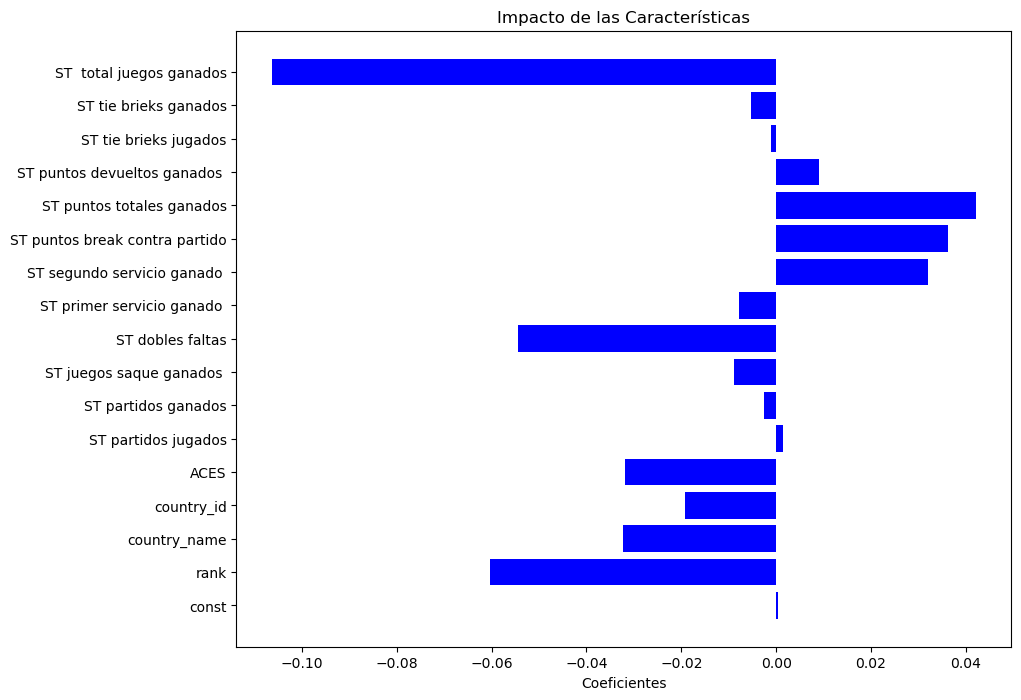

In [93]:
# Reentrenar el modelo después de asegurarte de que las columnas estén alineadas
model_sklearn = LogisticRegression()
model_sklearn.fit(X_train, y_train)

# Comprobando nuevamente los coeficientes y los nombres de las características
coefs = model_sklearn.coef_[0]
feature_names = X_train.columns

# Verificar si ahora coinciden en número
print("Número de Coeficientes:", len(coefs))
print("Número de Nombres de Características:", len(feature_names))

# Si están alineados, procede con la visualización
if len(coefs) == len(feature_names):
    plt.figure(figsize=(10, 8))
    plt.barh(feature_names, coefs, color='blue')
    plt.xlabel("Coeficientes")
    plt.title("Impacto de las Características")
    plt.show()
else:
    print("Los coeficientes y nombres de características todavía no coinciden.")

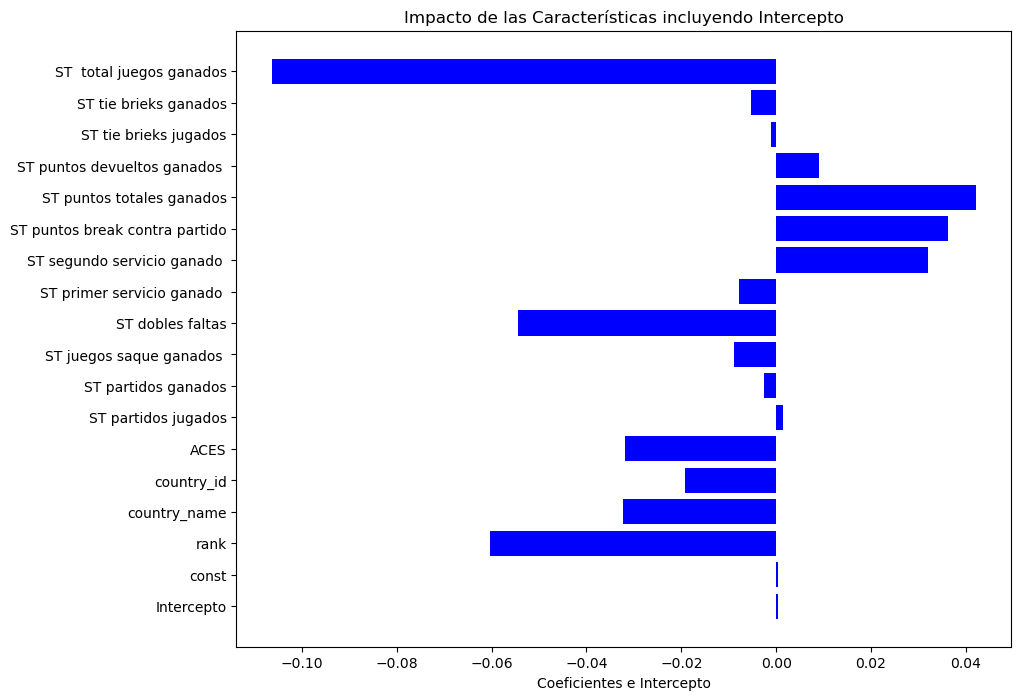

In [94]:
# Incluir el intercepto en la visualización si deseas
intercept = model_sklearn.intercept_[0]
full_coefs = np.append(intercept, coefs)  # Añade el intercepto al principio de los coeficientes
full_feature_names = ['Intercepto'] + list(feature_names)  # Añade 'Intercepto' al principio de los nombres de características

# Visualizar coeficientes incluyendo el intercepto
plt.figure(figsize=(10, 8))
plt.barh(full_feature_names, full_coefs, color='blue')
plt.xlabel("Coeficientes e Intercepto")
plt.title("Impacto de las Características incluyendo Intercepto")
plt.show()

## Crear la variable binaria

In [95]:
# Calcula la media de partidos ganados
media_partidos_ganados = df['ST partidos ganados'].mean()

# Crea una nueva columna 'win' que es 1 si el número de partidos ganados es mayor que la media, 0 de lo contrario
df['win'] = (df['ST partidos ganados'] > media_partidos_ganados).astype(int)

# Verificar los valores de la nueva columna 'win'
print(df['win'].value_counts())

win
0    132
1     37
Name: count, dtype: int64


In [96]:
# Variables predictoras
X = df[['rank','ST partidos jugados', 'ST juegos saque ganados ', 'ST primer servicio ganado ', 'ST segundo servicio ganado ', 'ST puntos break contra partido', 'ST puntos totales ganados']]

# Añadir una constante a X
X = sm.add_constant(X)

# Variable objetivo
y = df['win']

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Ajustar el modelo

In [98]:
# Llenar NaNs con la media de cada columna
X_train = X_train.fillna(X_train.mean())

In [99]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcular VIF para cada variable
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif_data)

                          feature         VIF
0                           const  691.913021
1                            rank    4.850305
2             ST partidos jugados    2.604874
3        ST juegos saque ganados     3.032660
4      ST primer servicio ganado     3.368148
5     ST segundo servicio ganado     1.350936
6  ST puntos break contra partido    1.487565
7       ST puntos totales ganados    5.549086


In [100]:
# Suponiendo que decides eliminar variables con VIF alto
high_vif_columns = vif_data[vif_data['VIF'] > 10]['feature'].tolist()
X_train_reduced = X_train.drop(columns=high_vif_columns)
X_test_reduced = X_test.drop(columns=high_vif_columns)

try:
    model_reduced = sm.Logit(y_train, X_train_reduced)
    result_reduced = model_reduced.fit()
    print(result_reduced.summary())
except Exception as e:
    print("Error al ajustar el modelo reducido:", e)

Optimization terminated successfully.
         Current function value: 0.035002
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                  118
Model:                          Logit   Df Residuals:                      111
Method:                           MLE   Df Model:                            6
Date:                Wed, 15 May 2024   Pseudo R-squ.:                  0.9290
Time:                        20:41:42   Log-Likelihood:                -4.1302
converged:                       True   LL-Null:                       -58.206
Covariance Type:            nonrobust   LLR p-value:                 4.968e-21
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
rank                               0.0137      0.060      0.230    

In [101]:
print(y_train.value_counts())

win
0    95
1    23
Name: count, dtype: int64


In [102]:
try:
    model = sm.Logit(y_train, X_train)
    result = model.fit(method='bfgs', maxiter=100)  # Usar un método de optimización diferente y más iteraciones
    print(result.summary())
except Exception as e:
    print("Error con configuración alternativa del ajuste:", e)

         Current function value: 0.031166
         Iterations: 100
         Function evaluations: 111
         Gradient evaluations: 106
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                  118
Model:                          Logit   Df Residuals:                      110
Method:                           MLE   Df Model:                            7
Date:                Wed, 15 May 2024   Pseudo R-squ.:                  0.9368
Time:                        20:41:43   Log-Likelihood:                -3.6776
converged:                      False   LL-Null:                       -58.206
Covariance Type:            nonrobust   LLR p-value:                 1.441e-20
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           -

## Limpieza de NaNs en Datos de Entrada

In [103]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# Crear el imputador que reemplazará cada NaN con la media de su columna
imputer = SimpleImputer(strategy='mean')

# Crear un modelo de regresión logística con regularización L2
model = LogisticRegression(penalty='l2', solver='liblinear', max_iter=100)

# Crear un pipeline que primero impute los valores, luego ajuste el modelo
pipeline = make_pipeline(imputer, model)

# Ajustar el pipeline al conjunto de entrenamiento
pipeline.fit(X_train, y_train)

# Evaluar el modelo
from sklearn.metrics import classification_report, roc_auc_score

# Predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Imprimir los resultados de evaluación
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

ROC AUC Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        14

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



## Validación cruzada de resultados

In [104]:
from sklearn.model_selection import cross_val_score

# Aplicar validación cruzada en el modelo
scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')
print("Promedio de puntuación ROC AUC en validación cruzada:", scores.mean())

Promedio de puntuación ROC AUC en validación cruzada: 0.9989010989010989


In [105]:
# Mostrar los coeficientes del modelo
print("Coeficientes del modelo:", pipeline.named_steps['logisticregression'].coef_)

Coeficientes del modelo: [[-0.01435691  0.00969151  0.03580745  0.05692573 -0.26384742 -0.30929645
  -0.53513538  0.03703433]]


## Grafico de la curva ROC AUC

In [106]:
# Asegúrate de que el pipeline ya está ajustado con el modelo que incluye el imputador y el clasificador
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

ROC AUC: 1.00


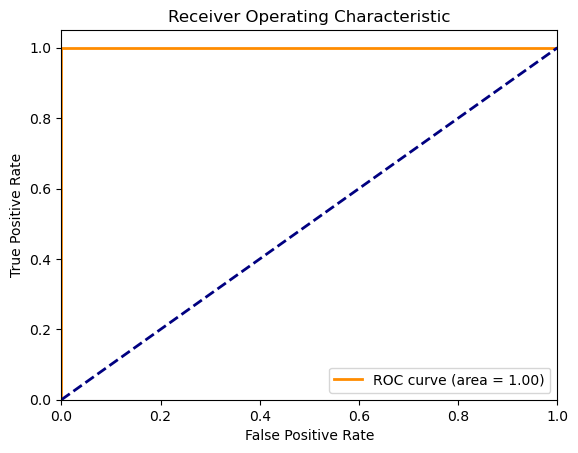

In [107]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular los valores de TPR y FPR para diferentes umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Imprimir el AUC
print('ROC AUC: %0.2f' % roc_auc)

# Graficar la Curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Cálculo de Recall y F1-Score

In [108]:
from sklearn.metrics import recall_score, f1_score

# Calcular recall y F1-score
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, average='binary')

print("Recall:", recall)
print("F1-Score:", f1)

Recall: 1.0
F1-Score: 1.0


## Validación cruzada de Recall y F1-Score

In [109]:
from sklearn.model_selection import cross_val_score

# Validación cruzada para el recall
recall_scores = cross_val_score(pipeline, X, y, cv=5, scoring='recall')
print("Promedio de puntuación de recall en validación cruzada:", recall_scores.mean())

# Validación cruzada para el F1-score
f1_scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
print("Promedio de puntuación de F1 en validación cruzada:", f1_scores.mean())

Promedio de puntuación de recall en validación cruzada: 0.9142857142857143
Promedio de puntuación de F1 en validación cruzada: 0.9172951231774761
